In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate data, store in `x_train`, `y_train`, `x_test`, `x_actual`. Ignore details. 

In [2]:
n_train = 100 #number training points
n_test = 1 #number testing points
n_f = n_train + n_test
n_in = 30 #number input features per point
n_out = 1 #number output features per point
n = n_in + n_out

# Kernel matrix generator
K_obs = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        K_obs[i,j] = np.abs(i-j)

#make n_f points, store each as a row in f_train
alldata = np.zeros((n, n_f))
for i in range(n_f):
    alldata[:,i] = np.random.multivariate_normal(np.zeros(n), K_obs)
    
x_train = alldata[:n_in, :n_train]
y_train = alldata[n_in:, :n_train].reshape(-1,1)
x_test = alldata[:n_in, n_train:]
y_actual = alldata[n_in:, n_train:].reshape(-1,1)

c:\users\yowza\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Actual GP prior. Start with prior $f \mid X\sim \mathcal{N}(0,K)$. Solve by GPR algorithm. 

In [14]:
#squared exponential covariance function
def sq_exp(xp, xq, length_scale=0.01): 
    return np.exp(-length_scale*np.linalg.norm(xp-xq)**2)

noise = 0.000001
k = sq_exp

def getK(Xp, Xq):
    assert Xp.shape[0] == Xq.shape[0], 'Xp, Xq have different numbers of features'
    K=np.zeros((Xp.shape[1],Xq.shape[1]))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i,j] = sq_exp(Xp[:,i], Xq[:,j])
    return K

m = 50

K = getK(x_train, x_train)
L = np.linalg.cholesky(K + np.identity(n_train) * noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train - m))
K_train_test = getK(x_train, x_test)
pred_mean = K_train_test.T @ alpha + m
v = np.linalg.solve(L, K_train_test) #covariances
pred_var = getK(x_test, x_test) - v.T @ v
log_marginal = -0.5 * y_train.T @ alpha - np.sum(np.log(np.diag(L))) - 0.5*n_train * np.log(2*np.pi)

In [15]:
y_actual, pred_mean, y_actual - pred_mean, pred_var

(array([[-1.72359849]]),
 array([[10.46888673]]),
 array([[-12.19248522]]),
 array([[0.87038167]]))

Test output (y-value) is at index 30 in chart below. Blue point is actual, orange is predicted. Error bar is 2 SDs. 

<ErrorbarContainer object of 3 artists>

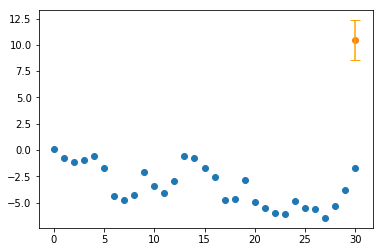

In [16]:
plt.close()
plt.scatter(np.arange(n), alldata[:,-1])
plt.scatter(n_in, pred_mean)
plt.errorbar(n_in, pred_mean, yerr=2*np.sqrt(pred_var), capsize=5, ecolor='orange')